In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dlr_boson as dlr
import scipy.linalg as slinalg
from scipy.linalg import lu_factor, lu_solve

In [2]:
def kernel(E, tau, beta):
    x = beta*E / 2
    y = 2.0*tau / beta - 1
    if -100.0 < x < 100.0:
        G = np.exp(-x * y) / (2 * np.cosh(x))
    elif x >= 100.0:
        G = np.exp(-x * (y + 1))
    else: # x<=-100.0
        G = np.exp(x * (1 - y))
    return G

In [3]:
def Polarisi(q,w,EF):
    """ Polarization P(q,iW) on imaginary axis. Note that the result is real.
        It works on arrays of frequency, i.e., w can be array of bosonic Matsubara points.
    """
    kF = np.sqrt(EF)
    q2 = q**2
    kFq = 2*kF*q
    D = 1./(8.*kF*q)
    
    if type(w)==np.ndarray:
        res = zeros(len(w),dtype=float)
        
        # careful for small q or large w
        is_w_large = w > 20*(q2+kFq) # for w[i>=iw_start] we should use power expansion
        iw_start = len(w)  # if this was newer true, is_w_large contains only False => iw_start=len(w)
        if is_w_large[-1] : # If at least the last frequency is larger than the cutoff, we can find the index
            iw_start = argmax( is_w_large )
        
        # if w < cutoff use exact expression
        iw = w[:iw_start]*1j
        wmq2 = iw-q2
        wpq2 = iw+q2
        C1 = np.log(wmq2-kFq)-np.log(wmq2+kFq)
        C2 = np.log(wpq2-kFq)-np.log(wpq2+kFq)
        res[:iw_start] = np.real( -kF/(4*np.pi**2) * (1. - D*(wmq2**2/q**2-4*EF)*C1 + D*(wpq2**2/q**2-4*EF)*C2) )
        # if w < cutoff use proper power expansion
        b2 = q2 * ( q2 + 12./5. * EF ) # b2==b^2
        c = 2*EF*kF*q2/(3*pi**2)
        res[iw_start:] = -c/(w[iw_start:]**2 + b2)
    else:
        # careful for small q or large w
        if  w <= 20*(q2+kFq) :
            iw = w*1j
            wmq2 = iw-q2
            wpq2 = iw+q2
            C1 = np.log(wmq2-kFq)-np.log(wmq2+kFq)
            C2 = np.log(wpq2-kFq)-np.log(wpq2+kFq)
            res = np.real( -kF/(4*np.pi**2) * (1. - D*(wmq2**2/q**2-4*EF)*C1 + D*(wpq2**2/q**2-4*EF)*C2) )
        else:
            b2 = q2 * ( q2 + 12./5. * EF )
            c = 2*EF*kF*q2/(3*np.pi**2)
            res = -c/(w**2 + b2)
    return res

In [4]:
Polarisi(0.01, 0.0, 1.0)

-0.05066016964745978

In [43]:
Wmax = 10.0
Nw = 10000
dW = Wmax/Nw
beta = 100.0
Nt = int(beta*Wmax*100)
Nwn = int(Wmax*beta/2.0/np.pi*100)
eps = 1.0e-12
print("Nt: ", Nt)
print("Nwn: ", Nwn)
k, wGrid, wnGrid, tGrid = dlr.getDLR(beta, Wmax, Nw, Nwn, Nt, eps)
for i in range(k):
    print(i, wGrid[i], tGrid[i], wnGrid[i])

Nt:  100000
Nwn:  15915
0 0.0 0.0010000100001050782 0
1 0.038 1.362013620136203 1
2 0.061 3.755037550375505 2
3 0.093 5.377053770537707 3
4 0.132 10.79810798107981 4
5 0.182 13.840638406384066 5
6 0.24 17.202672026720272 6
7 0.3 24.86574865748657 7
8 0.393 30.706307063070632 8
9 0.5 32.39932399323993 9
10 0.642 38.37588375883759 10
11 0.788 39.33889338893389 13
12 0.9480000000000001 42.36042360423603 15
13 1.154 49.08849088490885 18
14 1.379 50.91150911509115 21
15 1.699 57.63957639576396 25
16 2.164 60.66110661106612 29
17 2.736 61.62411624116241 35
18 3.085 67.60067600676007 42
19 3.515 69.29369293692936 54
20 4.359 75.13425134251344 68
21 5.0760000000000005 82.79732797327974 92
22 5.848 86.15936159361593 123
23 7.415 89.20189201892018 151
24 8.282 94.62294622946229 188
25 9.028 96.24496244962448 248
26 9.693 98.6379863798638 339
27 9.999 99.9989999899999 584


[-0.0495916  -0.0106113  -0.00364145 -0.00174987 -0.0010139  -0.00065815
 -0.00046064 -0.00034005 -0.00026116 -0.00020679]


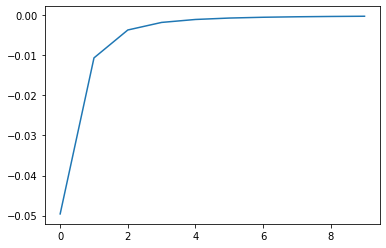

In [44]:
#wnlist=range(1000)
q=0.5
EF=1.0
P=np.array([Polarisi(q, wn, EF) for wn in wnGrid])
print(P[:10])
plt.figure()
plt.plot(wnGrid[:10], P[:10])
plt.show()

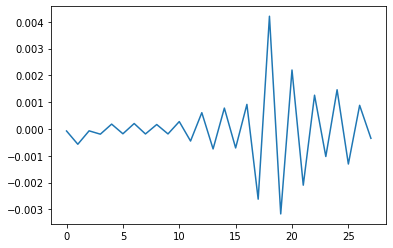

P(iwn) difference:  1.3552527156068805e-18


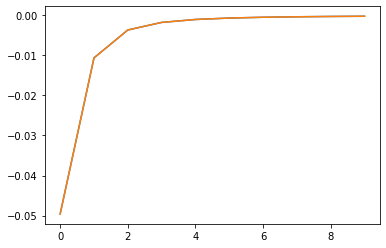

In [45]:
transfer=dlr.getKerW(wnGrid, wGrid, beta)
lu, piv = lu_factor(transfer)
# calculate the dlr coefficients
coeff = lu_solve((lu, piv), P)
plt.figure()
plt.plot(coeff)
plt.show()

Pfit=transfer @ coeff
print("P(iwn) difference: ", np.max(Pfit - P))
plt.figure()
plt.plot(wnGrid[:10], P[:10])
plt.plot(wnGrid[:10], Pfit[:10])
plt.show()

P(iwn) difference:  1.7024267221028215e-12


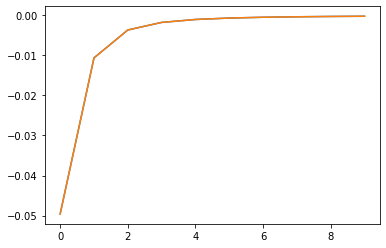

In [46]:
wnlist=np.array(range(10000))
kernel=dlr.getKerW(wnlist, wGrid, beta)
Pfine=np.array([Polarisi(q, wn, EF) for wn in wnlist])
Pfitfine=kernel @ coeff
print("P(iwn) difference: ", np.max(Pfitfine - Pfine))
plt.figure()
plt.plot(wnGrid[:10], P[:10])
plt.plot(wnGrid[:10], Pfit[:10])
plt.show()

In [104]:
from scipy import integrate

#f = lambda y, x: x*y**2

#def f(y, x):
#    return -kernel(y**2, 5.0, 25.0)*kernel(y**2, 20.0, 25.0)

def Green(E, tau, beta):
    x = beta*E / 2
    y = 2.0*tau / beta - 1
    if -100.0 < x < 100.0:
        G = np.exp(-x * y) / (2 * np.cosh(x))
    elif x >= 100.0:
        G = np.exp(-x * (y + 1))
    else: # x<=-100.0
        G = np.exp(x * (1 - y))
    return G

def Polar(k, theta, q, tau, beta, kF):
    return -Green(k*k-kF*kF, 5.0, 25.0)*Green((q+k*np.cos(theta))**2+k**2*np.sin(theta)**2-kF*kF, 20.0, 25.0)*k*k*np.sin(theta)/(2.0*np.pi)**2*2*25.0

#f=lambda y, x: -kernel(y**2, 5.0, 25.0)*kernel(y**2, 20.0, 25.0)
#kF=1.919
#f=lambda y, x: -Green(y*y-kF*kF, 5.0, 25.0)*Green(y*y-kF*kF, 20.0, 25.0)*y*y*np.sin(x)/(2.0*np.pi)**2*2*25.0

integrate.dblquad(Polar, 0, np.pi, lambda x: 0, lambda x: 15.0*kF*kF, args=(0.2, 1.0, 25.0, 1.919))

#integrate.dblquad(Polar, 0, np.pi, lambda x: 0, lambda x: 10.0*kF*kF)

#def Polarization(q, n, beta):
    

(-0.013961605793338067, 1.489994555861629e-08)

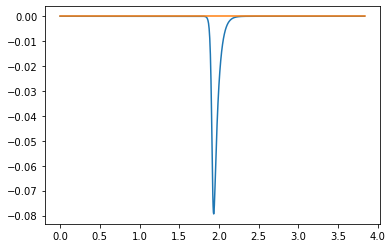

In [131]:
def Polar(theta, k, q, tau, beta, kF):
    return -Green(k*k-kF*kF, 5.0, 25.0)*Green((q+k*np.cos(theta))**2+k**2*np.sin(theta)**2-kF*kF, 20.0, 25.0)*k*k*np.sin(theta)/(2.0*np.pi)**2*2*25.0
#def Polar(theta, k, q, tau, beta, kF):
#    return -Green(k*k-kF*kF, 5.0, 25.0)*Green(k*k-kF*kF, 20.0, 25.0)*k*k*np.sin(theta)/(2.0*np.pi)**2*2*25.0

klist=np.array(range(1000))*1.919*2/1000
polar=[integrate.quad(Polar, 0.0, np.pi, args=(k, 2.0, 0.0, 25.0, 1.919)) for k in klist]

plt.figure()
plt.plot(klist, polar)
plt.show()

#integrate.quad(Polar, 0.0, np.pi, args=(1.919, 0.5, 1.0, 25.0, 1.919))

In [75]:
f=lambda y: -Green(y*y-kF*kF, 5.0, 25.0)*Green(y*y-kF*kF, 20.0, 25.0)*y*y/(2.0*np.pi)**3*4*np.pi*2*25.0
integrate.quad(f, 0.0, 10.0*kF*kF)

(-0.09721295642810059, 1.0948723621077593e-09)

In [107]:
import mcint
import random
import math

def w(r, theta, phi, alpha, beta, gamma):
    return(-math.log(theta * beta))

def integrand(x):
    r     = x[0]
    theta = x[1]
    alpha = x[2]
    beta  = x[3]
    gamma = x[4]
    phi   = x[5]

    k = 1.
    T = 1.
    ww = w(r, theta, phi, alpha, beta, gamma)
    return (math.exp(-ww/(k*T)) - 1.)*r*r*math.sin(beta)*math.sin(theta)

def sampler():
    while True:
        r     = random.uniform(0.,1.)
        theta = random.uniform(0.,2.*math.pi)
        alpha = random.uniform(0.,2.*math.pi)
        beta  = random.uniform(0.,2.*math.pi)
        gamma = random.uniform(0.,2.*math.pi)
        phi   = random.uniform(0.,math.pi)
        yield (r, theta, alpha, beta, gamma, phi)


domainsize = math.pow(2*math.pi,4)*math.pi*1
expected = 16*math.pow(math.pi,5)/3.

for nmc in [1000, 10000, 100000, 1000000, 10000000, 100000000]:
    random.seed(1)
    result, error = mcint.integrate(integrand, sampler(), measure=domainsize, n=nmc)
    diff = abs(result - expected)

    print "Using n = ", nmc
    print "Result = ", result, "estimated error = ", error
    print "Known result = ", expected, " error = ", diff, " = ", 100.*diff/expected, "%"
    print " "

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Using n = ", nmc)? (<ipython-input-107-74f6beaf055b>, line 40)

In [93]:
import numpy.linalg as linalg
u, s, v=linalg.svd(transfer)
s

array([9.35233688e+00, 8.79255038e+00, 3.78777266e+00, 2.96053948e+00,
       1.56457255e+00, 9.78498222e-01, 5.53836379e-01, 3.12567980e-01,
       1.87341617e-01, 9.75573112e-02, 5.56524083e-02, 2.77148944e-02,
       1.50116830e-02, 7.64613408e-03, 3.85592187e-03, 1.93492500e-03,
       9.85016418e-04, 4.52897706e-04, 2.14140184e-04, 1.02341428e-04,
       4.92803587e-05, 2.16659899e-05, 1.01087001e-05, 4.28828633e-06,
       1.91607507e-06, 8.54919077e-07, 3.75250069e-07, 1.47712648e-07,
       5.97019802e-08, 2.34843359e-08, 9.65421676e-09, 3.60403050e-09,
       1.58369855e-09, 5.32362829e-10, 2.29457507e-10, 8.18463008e-11,
       2.89821412e-11, 1.21248443e-11, 3.54257810e-12, 1.40468766e-12,
       4.17550347e-13, 7.63398797e-14, 3.49054231e-14])

In [94]:
G=np.zeros(len(tauGrid))
E=0.1
for ti, t in enumerate(tauGrid):
    G[ti]=np.exp(-E*t)/(1.0+np.exp(-E*beta))

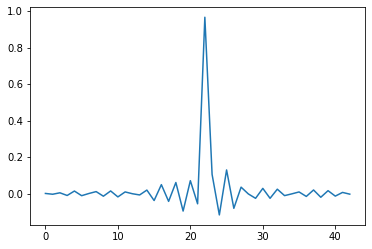

In [95]:
coeff=np.dot(linalg.pinv(transfer, 1.0e-12), G)
coeff
plt.figure()
plt.plot(coeff)
plt.show()

In [96]:
np.dot(transfer, coeff)-G

array([-1.63918337e-06, -1.71243007e-06, -1.81452838e-06, -1.78933682e-06,
       -1.38819856e-06, -9.22278487e-07, -6.19454466e-07, -3.52504065e-07,
       -2.01321932e-07, -8.30779859e-08, -3.04470965e-08, -1.78783877e-08,
       -1.87375834e-08, -2.40855579e-08, -3.00691521e-08, -3.37096530e-08,
       -3.56057119e-08, -3.60893585e-08, -3.64843135e-08, -3.77683173e-08,
       -4.09973099e-08, -4.68556889e-08, -5.09536131e-08, -5.48125919e-08,
       -6.36482202e-08, -6.96011207e-08, -7.04482601e-08, -6.77358643e-08,
       -6.15752723e-08, -5.16170512e-08, -4.20490122e-08, -3.87544066e-08,
       -4.45946518e-08, -6.25232109e-08, -9.59928877e-08, -2.23083120e-07,
       -3.36825825e-07, -4.79467865e-07, -9.39721834e-07, -1.63325510e-06,
       -2.07788560e-06, -2.55812041e-06, -3.03694789e-06])

In [97]:
result=np.sum([kernel(wGrid[wi], 0.0, beta)*coeff[wi] for wi in range(len(wGrid))])
expect=1.0/(1.0+np.exp(-E*beta))
print(result, expect)

0.9241401825731594 0.9241418199787566


In [99]:
linalg.solve(transfer, G)

array([ 2.97704103e-04, -8.17862044e-04,  1.62021915e-03, -5.27424049e-03,
        1.26204777e-02, -2.11784428e-02,  2.46255576e-02, -2.99475450e-02,
        2.59033026e-02, -2.63241552e-02,  3.90871170e-02, -3.63519728e-02,
        2.58115548e-02, -2.14267080e-02,  3.23205584e-02, -4.81058980e-02,
        5.46905233e-02, -4.27904657e-02,  5.79246585e-02, -8.93942534e-02,
        6.70917467e-02, -5.32908820e-02,  9.63565115e-01,  1.12428776e-01,
       -1.43631415e-01,  1.82053154e-01, -1.43535473e-01,  1.00543037e-01,
       -1.21801683e-01,  1.42104537e-01, -7.48423835e-02,  3.52315477e-02,
       -3.10701760e-02,  1.56740472e-02, -7.12630538e-03,  6.09468308e-03,
       -4.28768942e-03,  2.88106484e-03, -1.91522927e-03,  1.04284981e-03,
       -6.87388247e-04,  2.90522311e-04, -1.02585912e-04])

In [100]:
import scipy.linalg as slinalg
from scipy.linalg import lu_factor, lu_solve

In [101]:
lu, piv = lu_factor(transfer)

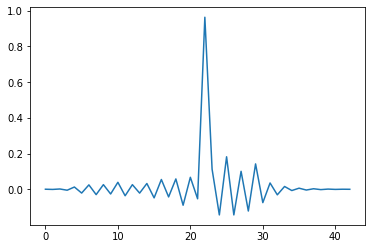

In [102]:
x = lu_solve((lu, piv), G)
x
plt.figure()
plt.plot(x)
plt.show()

In [103]:
transfer @ x - G

array([ 3.33066907e-16,  3.33066907e-16,  2.22044605e-16,  0.00000000e+00,
        3.33066907e-16,  4.44089210e-16,  3.33066907e-16,  2.22044605e-16,
        4.44089210e-16,  0.00000000e+00,  3.33066907e-16,  1.11022302e-16,
        1.11022302e-16,  2.22044605e-16,  1.11022302e-16,  2.22044605e-16,
       -1.11022302e-16,  0.00000000e+00, -5.55111512e-17, -5.55111512e-17,
        0.00000000e+00,  0.00000000e+00, -5.55111512e-17, -8.32667268e-17,
       -2.77555756e-17, -2.77555756e-17,  2.77555756e-17,  0.00000000e+00,
        0.00000000e+00, -1.38777878e-17, -2.77555756e-17,  0.00000000e+00,
       -1.38777878e-17, -1.38777878e-17,  0.00000000e+00,  2.77555756e-17,
        1.38777878e-17,  5.55111512e-17,  0.00000000e+00,  4.16333634e-17,
       -6.93889390e-17,  5.55111512e-17, -1.38777878e-17])